In [282]:
import pandas as pd

# classification dataset for voting ensemble
classification_data = pd.read_csv("./classification_data_cleaned.csv")
# regression dataset for decision tree models 
regression_data = pd.read_csv("./regression_data_cleaned.csv")


In [283]:
# prepare data for classification
from sklearn.model_selection import train_test_split

# Features and target
x_clf = classification_data.drop(columns=["Mortality_Status"])
y_clf = classification_data["Mortality_Status"]

# Train-test split
x_train_clf, x_test_clf, y_train_clf, y_test_clf = train_test_split(
    x_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

# inspect and encode
print(x_train_clf.dtypes[x_train_clf.dtypes == 'object'])




6th_Stage         object
Differentiated    object
A_Stage           object
dtype: object


In [284]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import pandas as pd

# Step 1: One-hot encode the 3 object columns
x_train_clf = pd.get_dummies(x_train_clf, columns=['6th_Stage', 'Differentiated', 'A_Stage'], drop_first=True)
x_test_clf = pd.get_dummies(x_test_clf, columns=['6th_Stage', 'Differentiated', 'A_Stage'], drop_first=True)

# Step 2: Align the test set to have the same columns as train set
x_train_clf, x_test_clf = x_train_clf.align(x_test_clf, join='left', axis=1, fill_value=0)

imputer = SimpleImputer(strategy='median')
x_train_clf = imputer.fit_transform(x_train_clf)
x_test_clf = imputer.transform(x_test_clf)

# Step 3: Standardize the features
scaler = StandardScaler()
x_train_clf_scaled = scaler.fit_transform(x_train_clf)
x_test_clf_scaled = scaler.transform(x_test_clf)


In [285]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Create base models
lr = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier(n_neighbors=5)

# Ensemble: Voting
voting_clf = VotingClassifier(
    estimators=[("lr", lr), ("knn", knn)],
    voting='soft' 
)

voting_clf.fit(x_train_clf_scaled, y_train_clf)


VotingClassifier(estimators=[('lr', LogisticRegression(max_iter=1000)),
                             ('knn', KNeighborsClassifier())],
                 voting='soft')

In [286]:
# re-usable confusion metrics function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, x_test, y_test, model_name="Model", cmap='Blues'):
    y_pred = model.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=cmap)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()


In [287]:
# re-useable function for classification report
from sklearn.metrics import classification_report

def print_classification_report(model, x_test, y_test, model_name="Model"):
    y_pred = model.predict(x_test)
    print(f"\nClassification Report - {model_name}")
    print(classification_report(y_test, y_pred))

In [288]:
# re-usable roc-curve function
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# custom ROC Curve 
def plot_custom_roc_curve(model, x_test, y_test, model_name="Model"):
    y_probs = model.predict_proba(x_test)[:, 1]
    false_positive_rate, true_positive_rate, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(false_positive_rate, true_positive_rate)

    plt.figure(figsize=(6, 4))
    plt.plot(false_positive_rate, true_positive_rate, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


In [289]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()
knn_model.fit(x_train_clf_scaled, y_train_clf)

KNeighborsClassifier()

In [290]:
# logistic regression
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=5000)
lr_model.fit(x_train_clf_scaled, y_train_clf)


LogisticRegression(max_iter=5000)

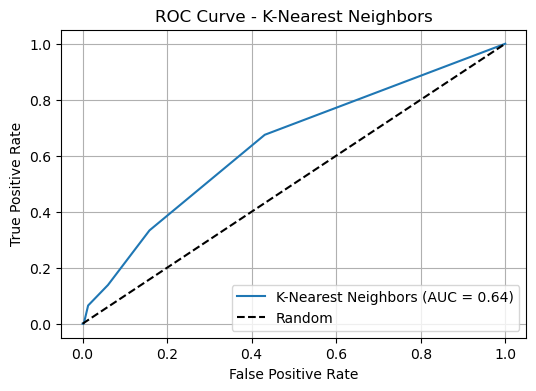

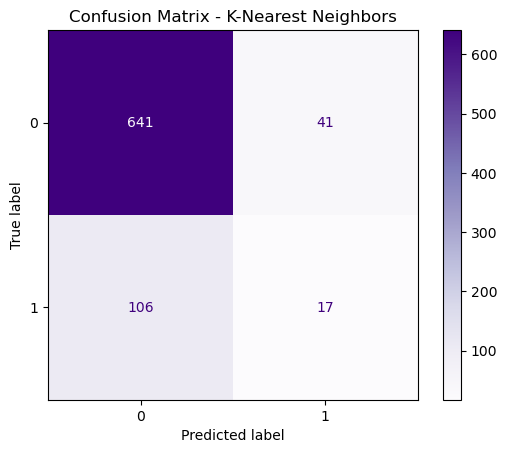


Classification Report - K-Nearest Neighbors
              precision    recall  f1-score   support

           0       0.86      0.94      0.90       682
           1       0.29      0.14      0.19       123

    accuracy                           0.82       805
   macro avg       0.58      0.54      0.54       805
weighted avg       0.77      0.82      0.79       805



In [291]:
plot_custom_roc_curve(knn_model, x_test_clf_scaled, y_test_clf, "K-Nearest Neighbors")
plot_confusion_matrix(knn_model, x_test_clf_scaled, y_test_clf, model_name="K-Nearest Neighbors", cmap='Purples')
print_classification_report(knn_model, x_test_clf_scaled, y_test_clf, model_name="K-Nearest Neighbors")


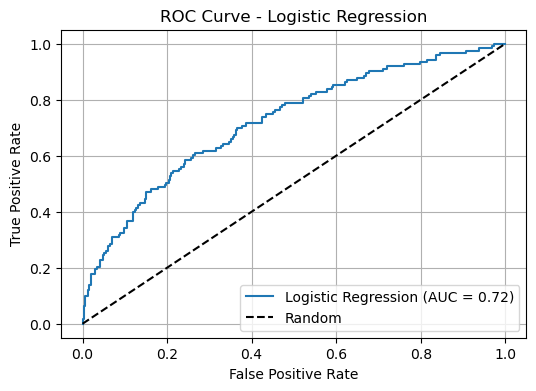

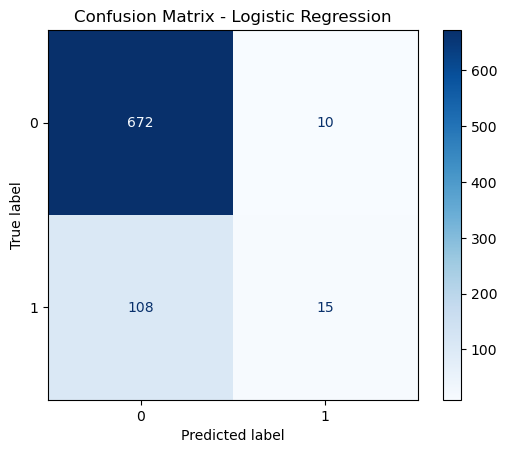


Classification Report - Logistic Regression
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       682
           1       0.60      0.12      0.20       123

    accuracy                           0.85       805
   macro avg       0.73      0.55      0.56       805
weighted avg       0.82      0.85      0.81       805



In [292]:
plot_custom_roc_curve(lr_model, x_test_clf_scaled, y_test_clf, "Logistic Regression")
plot_confusion_matrix(lr_model, x_test_clf_scaled, y_test_clf, model_name="Logistic Regression")
print_classification_report(lr_model, x_test_clf_scaled, y_test_clf, model_name="Logistic Regression")

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.97      0.91       682
           1       0.43      0.12      0.19       123

    accuracy                           0.84       805
   macro avg       0.64      0.55      0.55       805
weighted avg       0.79      0.84      0.80       805

AUC Score: 0.7009989747991321


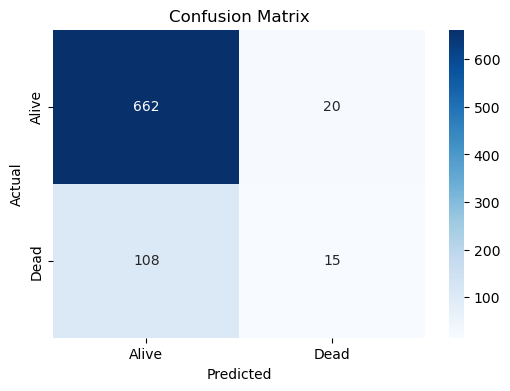

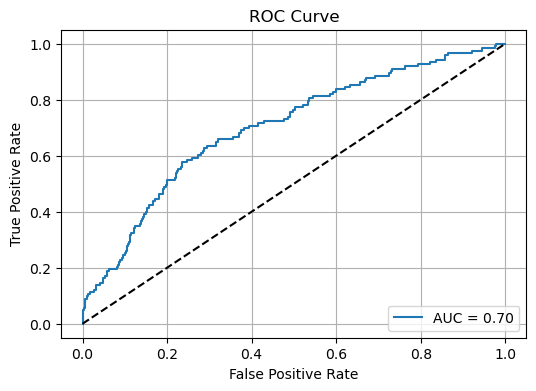

In [293]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve

# Predictions and probabilities
y_pred = voting_clf.predict(x_test_clf_scaled)
y_probs = voting_clf.predict_proba(x_test_clf_scaled)[:, 1]

# Classification report and AUC score
print("Classification Report:\n", classification_report(y_test_clf, y_pred))
print("AUC Score:", roc_auc_score(y_test_clf, y_probs))

# Confusion Matrix
cm = confusion_matrix(y_test_clf, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Alive", "Dead"], yticklabels=["Alive", "Dead"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_clf, y_probs)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test_clf, y_probs):.2f}")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [294]:
# prepare the regression data
x_reg = regression_data.drop(columns=["Survival_Months"])
y_reg = regression_data["Survival_Months"]

x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(
    x_reg, y_reg, test_size=0.2, random_state=42
)


In [295]:
x_train_reg = pd.get_dummies(x_train_reg, drop_first=True)
x_test_reg = pd.get_dummies(x_test_reg, drop_first=True)

# Align columns so test matches train
x_train_reg, x_test_reg = x_train_reg.align(x_test_reg, join="left", axis=1, fill_value=0)


In [296]:
# train decision tree models
from sklearn.tree import DecisionTreeRegressor, plot_tree

# Fully grown tree
dt1 = DecisionTreeRegressor(random_state=42)
dt1.fit(x_train_reg, y_train_reg)

# Pruned tree (max_depth = 4)
dt2 = DecisionTreeRegressor(max_depth=4, random_state=42)
dt2.fit(x_train_reg, y_train_reg)

DecisionTreeRegressor(max_depth=4, random_state=42)

In [297]:
# evaluate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def evaluate_regressor(model, x_test, y_test, name):
    y_pred = model.predict(x_test)
    print(f"--- {name} ---")
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("MSE:", mean_squared_error(y_test, y_pred))
    print("R²:", r2_score(y_test, y_pred))
    print()

evaluate_regressor(dt1, x_test_reg, y_test_reg, "Fully Grown Tree")
evaluate_regressor(dt2, x_test_reg, y_test_reg, "Pruned Tree (max_depth=4)")

--- Fully Grown Tree ---
MAE: 24.572580645161292
MSE: 1112.1693548387098
R²: -1.024800038647197

--- Pruned Tree (max_depth=4) ---
MAE: 19.217036486754594
MSE: 597.6416745236027
R²: -0.08805810950263004



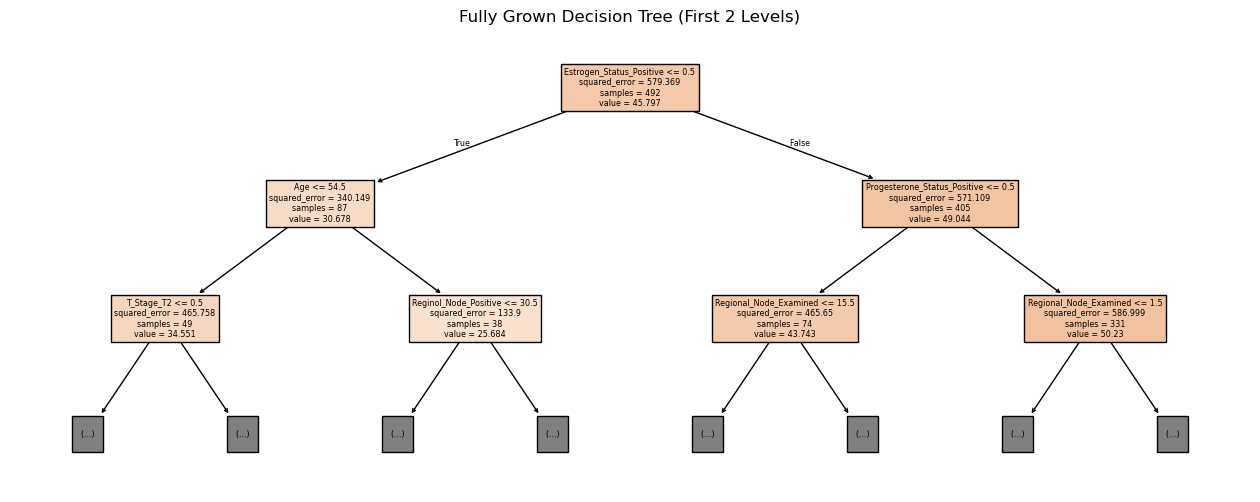

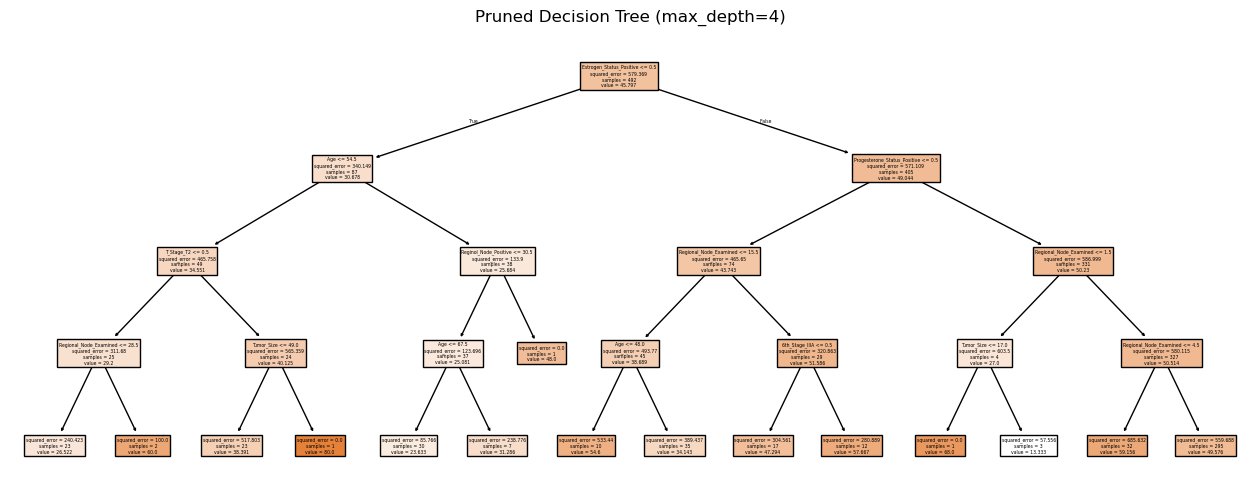

In [298]:
import matplotlib.pyplot as plt


# visualize tree
plt.figure(figsize=(16, 6))
plot_tree(dt1, filled=True, max_depth=2, feature_names=x_train_reg.columns)
plt.title("Fully Grown Decision Tree (First 2 Levels)")
plt.show()

plt.figure(figsize=(16, 6))
plot_tree(dt2, filled=True, feature_names=x_train_reg.columns)
plt.title("Pruned Decision Tree (max_depth=4)")
plt.show()